### Objetivo do Desafio

Utilizar a base histórica fictícia fornecida para projetar os seguintes indicadores por loja e por mês, no período de julho/2024 a junho/2025:

1. Diárias Locadas
2. Diária Média

### Sobre a Base de Dados

A base fornecida contém registros simulados de contratos de locação com as seguintes colunas:

* id_contrato
* data_inicio_locacao
* duracao_locacao (dias)
* id_loja
* cidade, estado
* dias_antecedencia (entre reserva e início locação)
* categoria_veiculo
* diaria_media
* valor_total_locacao (diaria_media x duração_locacao)

### Etapas Esperadas

Você deve realizar todas as etapas do pipeline de ciência de dados:

1. Análise Exploratória dos Dados: Análise do contexto e das variáveis, identificação de tendências, padrões sazonais e diferenças entre lojas, categorias e preços.

2. Análise Descritiva

3. Modelagem Preditiva:

    * Utilize pelo menos 4 modelos diferentes para previsão dos dois indicadores (ex.: regressão linear, ARIMA/Prophet, Random Forest, XGBoost, LSTM, etc).
    * Avalie os modelos com métricas apropriadas: RMSE, MAE, MAPE.
    * Explique as diferenças entre os modelos e suas vantagens/desvantagens.
    * Use validação apropriada (ex.: backtesting)
    * Pode apresentar graficamente as curvas e intervalos de confiança.

4. Interpretação e Insights: Destaque quais variáveis mais influenciam os resultados. Mostre comparações entre os modelos e recomende qual usar.

### Entrega Esperada

1. Notebook com todas as etapas comentadas: análise, preparação, modelagem e previsão.

2. Apresentação executiva (PDF ou slides).


In [2]:
# Imports

import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from matplotlib.ticker import MultipleLocator
import locale

from statsmodels.tsa.seasonal import MSTL

In [3]:
# Auxiliaries Functions


def sturges_bins(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)] 
    n = len(x)
    if n <= 1:
        return 1, np.inf

    k = math.ceil(math.log2(n)) + 1
    data_range = x.max() - x.min()
    h = data_range / k if data_range > 0 else np.inf
    return k, h

In [4]:
# Data Reading

df = pd.read_excel("../data/Desafio Inteligência (Cientista de Dados).xlsx")

In [5]:
# Display Dataframe
# Visualização das principais estatísticas do conjunto de dados

display(df.head())
display(df.info())
display(df.describe())

,id_contrato,data_inicio_locacao,duracao_locacao,id_loja,cidade,estado,dias_antecedencia,categoria_veiculo,diaria_media,valor_total_locacao,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,CTR0000001,2022-01-27,8,LJ_01,Recife,DF,13,EconÃ´mico,91.22,729.76,NaN,NaN,NaN,NaN,NaN,NaN
1,CTR0000002,2022-01-31,9,LJ_01,Curitiba,MG,9,IntermediÃ¡rio,78.70,708.30,NaN,NaN,NaN,NaN,NaN,NaN
2,CTR0000003,2022-01-10,7,LJ_01,Rio de Janeiro,MG,16,SUV,143.14,1001.98,NaN,NaN,NaN,NaN,NaN,NaN
3,CTR0000004,2022-01-28,7,LJ_01,Belo Horizonte,RS,4,IntermediÃ¡rio,135.86,951.02,NaN,NaN,NaN,NaN,NaN,NaN
4,CTR0000005,2022-01-28,9,LJ_01,Porto Alegre,PE,9,IntermediÃ¡rio,104.02,936.18,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140249 entries, 0 to 140248
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id_contrato          140249 non-null  object        
 1   data_inicio_locacao  140249 non-null  datetime64[ns]
 2   duracao_locacao      140249 non-null  int64         
 3   id_loja              140249 non-null  object        
 4   cidade               140249 non-null  object        
 5   estado               140249 non-null  object        
 6   dias_antecedencia    140249 non-null  int64         
 7   categoria_veiculo    140249 non-null  object        
 8   diaria_media         140249 non-null  float64       
 9   valor_total_locacao  140249 non-null  float64       
 10  Unnamed: 10          0 non-null       float64       
 11  Unnamed: 11          0 non-null       float64       
 12  Unnamed: 12          0 non-null       float64       
 13  Unnamed: 13   

None

,data_inicio_locacao,duracao_locacao,dias_antecedencia,diaria_media,valor_total_locacao,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 15
count,140249,140249.000000,140249.000000,140249.000000,140249.000000,0.0,0.0,0.0,0.0,10.000000
mean,2023-03-13 18:31:13.553465600,6.347439,15.019287,120.045161,761.950563,NaN,NaN,NaN,NaN,0.100000
min,2022-01-01 00:00:00,1.000000,0.000000,-5.190000,-31.140000,NaN,NaN,NaN,NaN,0.020000
25%,2022-08-01 00:00:00,5.000000,7.000000,99.750000,516.800000,NaN,NaN,NaN,NaN,0.055000
50%,2023-02-24 00:00:00,6.000000,15.000000,120.140000,728.560000,NaN,NaN,NaN,NaN,0.090000
75%,2023-11-03 00:00:00,8.000000,23.000000,140.220000,970.740000,NaN,NaN,NaN,NaN,0.117500
max,2024-06-30 00:00:00,16.000000,30.000000,259.860000,2875.800000,NaN,NaN,NaN,NaN,0.220000
std,NaN,2.271802,8.943597,30.002451,339.808277,NaN,NaN,NaN,NaN,0.066667


In [6]:
# Data Processing
# Limpeza dos dados

df.categoria_veiculo = df.categoria_veiculo.replace(
    {"IntermediÃ¡rio": "Intermediário", "EconÃ´mico": "Econômico"}
)
df.cidade = df.cidade.replace({"BrasÃ­lia": "Brasília", "SÃ£o Paulo": "São Paulo"})

for column_name in df.columns:
    if "Unnamed" in column_name:
        df.drop(column_name, axis=1, inplace=True)

# Column Names

numerical_columns = [
    "duracao_locacao",
    "dias_antecedencia",
    "diaria_media",
    "valor_total_locacao",
]
categorical_columns = [
    "estado",
    "cidade",
    "id_loja",
    "id_contrato",
    "categoria_veiculo",
]

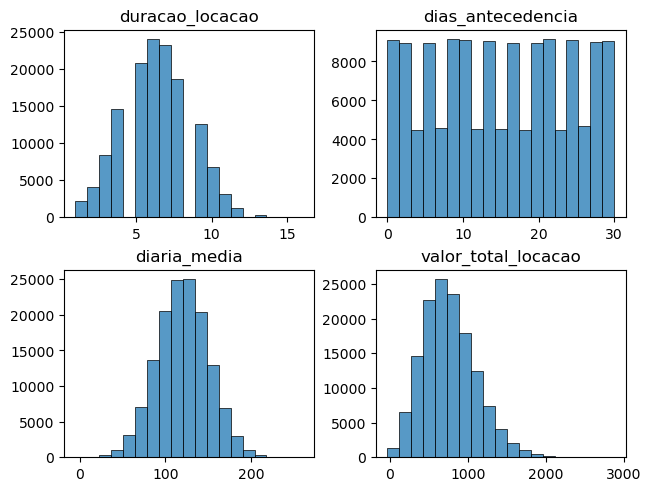

In [7]:
# Plot of Histograms
# Histograma das variáveis numéricas

fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True)
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    k, h = sturges_bins(df.loc[:, col].values)
    sns.histplot(data=df, x=col, ax=axes[idx], bins=k, binwidth=h, linewidth=0.5)
    axes[idx].set_title(f"{col}")
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")

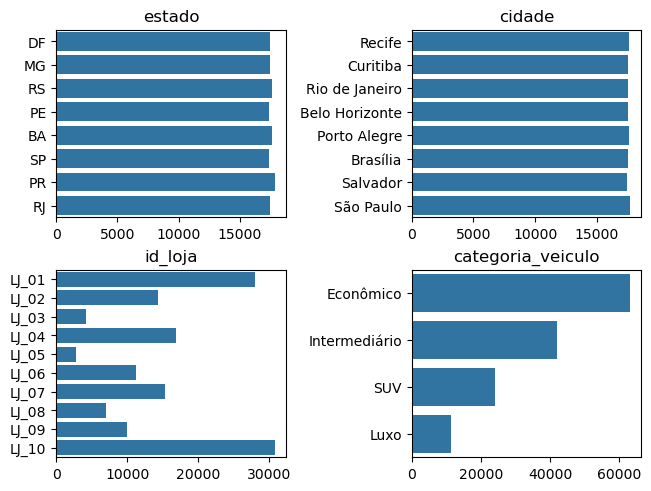

In [8]:
# Plot of Bars
# Gráfico de barra das variáveis categóricas

fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True)
axes = axes.flatten()

idx = 0
for col in categorical_columns:
    if col != "id_contrato":
        sns.countplot(data=df.loc[:, col], ax=axes[idx], linewidth=0.5)
        axes[idx].set_title(f"{col}")
        axes[idx].set_xlabel("")
        axes[idx].set_ylabel("")

        idx += 1

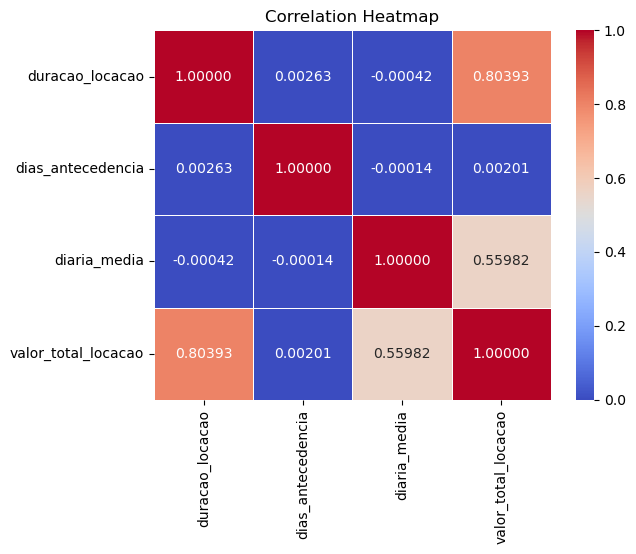

In [9]:
# Plot of Correlations
# Análise de correlação entre as variáveis numéricas. Não foi identificado nenhuma correlação forte (além do esperado
# entre duracao_locacao e valor_total_locacao)

corr_matrix = df.loc[:, numerical_columns].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".5f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Text(0, 0.5, 'Frequência')

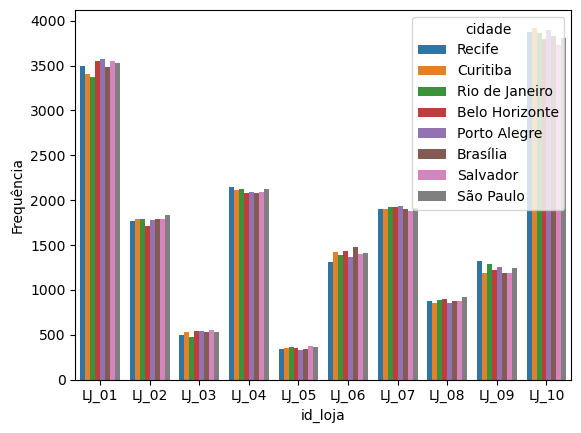

In [10]:
# cidades by id_loja
# A partir do gráfico abaixo, é possível observar a inconsistência entre a variáveis cidade e id_loja, visto que,
# a variável id_loja é do tipo única, não pode estar associada a mais de uma cidade. O mesmo se aplica a variável
# estado. Portanto, deve-se desconsiderar ambas as variáveis cidade e estado

plt.figure()
sns.countplot(x="id_loja", hue="cidade", data=df, linewidth=0.5)
plt.ylabel("Frequência")

### Variáveis Relevantes

* Dados Categóricos:
    * id_loja
    * id_contrato
    * categoria_veiculo

* Dados Temporais:
    * data_inicio_locacao

* Dados Numéricos
    * duracao_locacao
    * dias_antecedencia
    * diaria_media
    * valor_total_locacao

As variáveis estado e cidade foram desconsideradas, devido a inconsistência dos dados.

In [11]:
# Export Data
# Excluindo colunas desnecessárias para visualização de dados no dashboard

df.drop(["cidade", "estado"], axis=1, inplace=True)
df.id_loja = df.id_loja.str.replace("_", " ")

display(df.head())
# df.to_excel("../data/edited_dataset.xlsx")

,id_contrato,data_inicio_locacao,duracao_locacao,id_loja,dias_antecedencia,categoria_veiculo,diaria_media,valor_total_locacao
0,CTR0000001,2022-01-27,8,LJ 01,13,Econômico,91.22,729.76
1,CTR0000002,2022-01-31,9,LJ 01,9,Intermediário,78.70,708.30
2,CTR0000003,2022-01-10,7,LJ 01,16,SUV,143.14,1001.98
3,CTR0000004,2022-01-28,7,LJ 01,4,Intermediário,135.86,951.02
4,CTR0000005,2022-01-28,9,LJ 01,9,Intermediário,104.02,936.18


In [12]:
# Dashboard
# Foi desenvolvido um dashboard utilizando o framework streamlit e a biblioteca plotly para visualização iterativa
# de alguns indicadores, os principais resultados são gerados novamente abaixo

# Imports

import streamlit as st
import plotly.express as px

import subprocess
import os

# Auxiliares Functions


def dashboard_execution(df):
    pass


# Execution

if __name__ == "__main__":
    dashboard_execution(df)

In [157]:
# Dashboard Execution


def run_streamlit_dashboard(script_path):
    try:
        script_dir = os.path.dirname(script_path)
        script_name = os.path.basename(script_path)

        print(f"Iniciando o dashboard Streamlit em http://localhost:8501")

        command = ["streamlit", "run", script_name]
        process = subprocess.Popen(
            command,
            cwd=script_dir,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )

        return process

    except FileNotFoundError:
        print(
            "Erro: Streamlit não encontrado. Certifique-se de que está instalado e no PATH."
        )
    except Exception as e:
        print(f"Ocorreu um erro: {e}")


dashboard_path = "../src/dashboard.py"
streamlit_process = run_streamlit_dashboard(dashboard_path)

Iniciando o dashboard Streamlit em http://localhost:8501


In [14]:
# Closes Dashboard

streamlit_process.terminate()

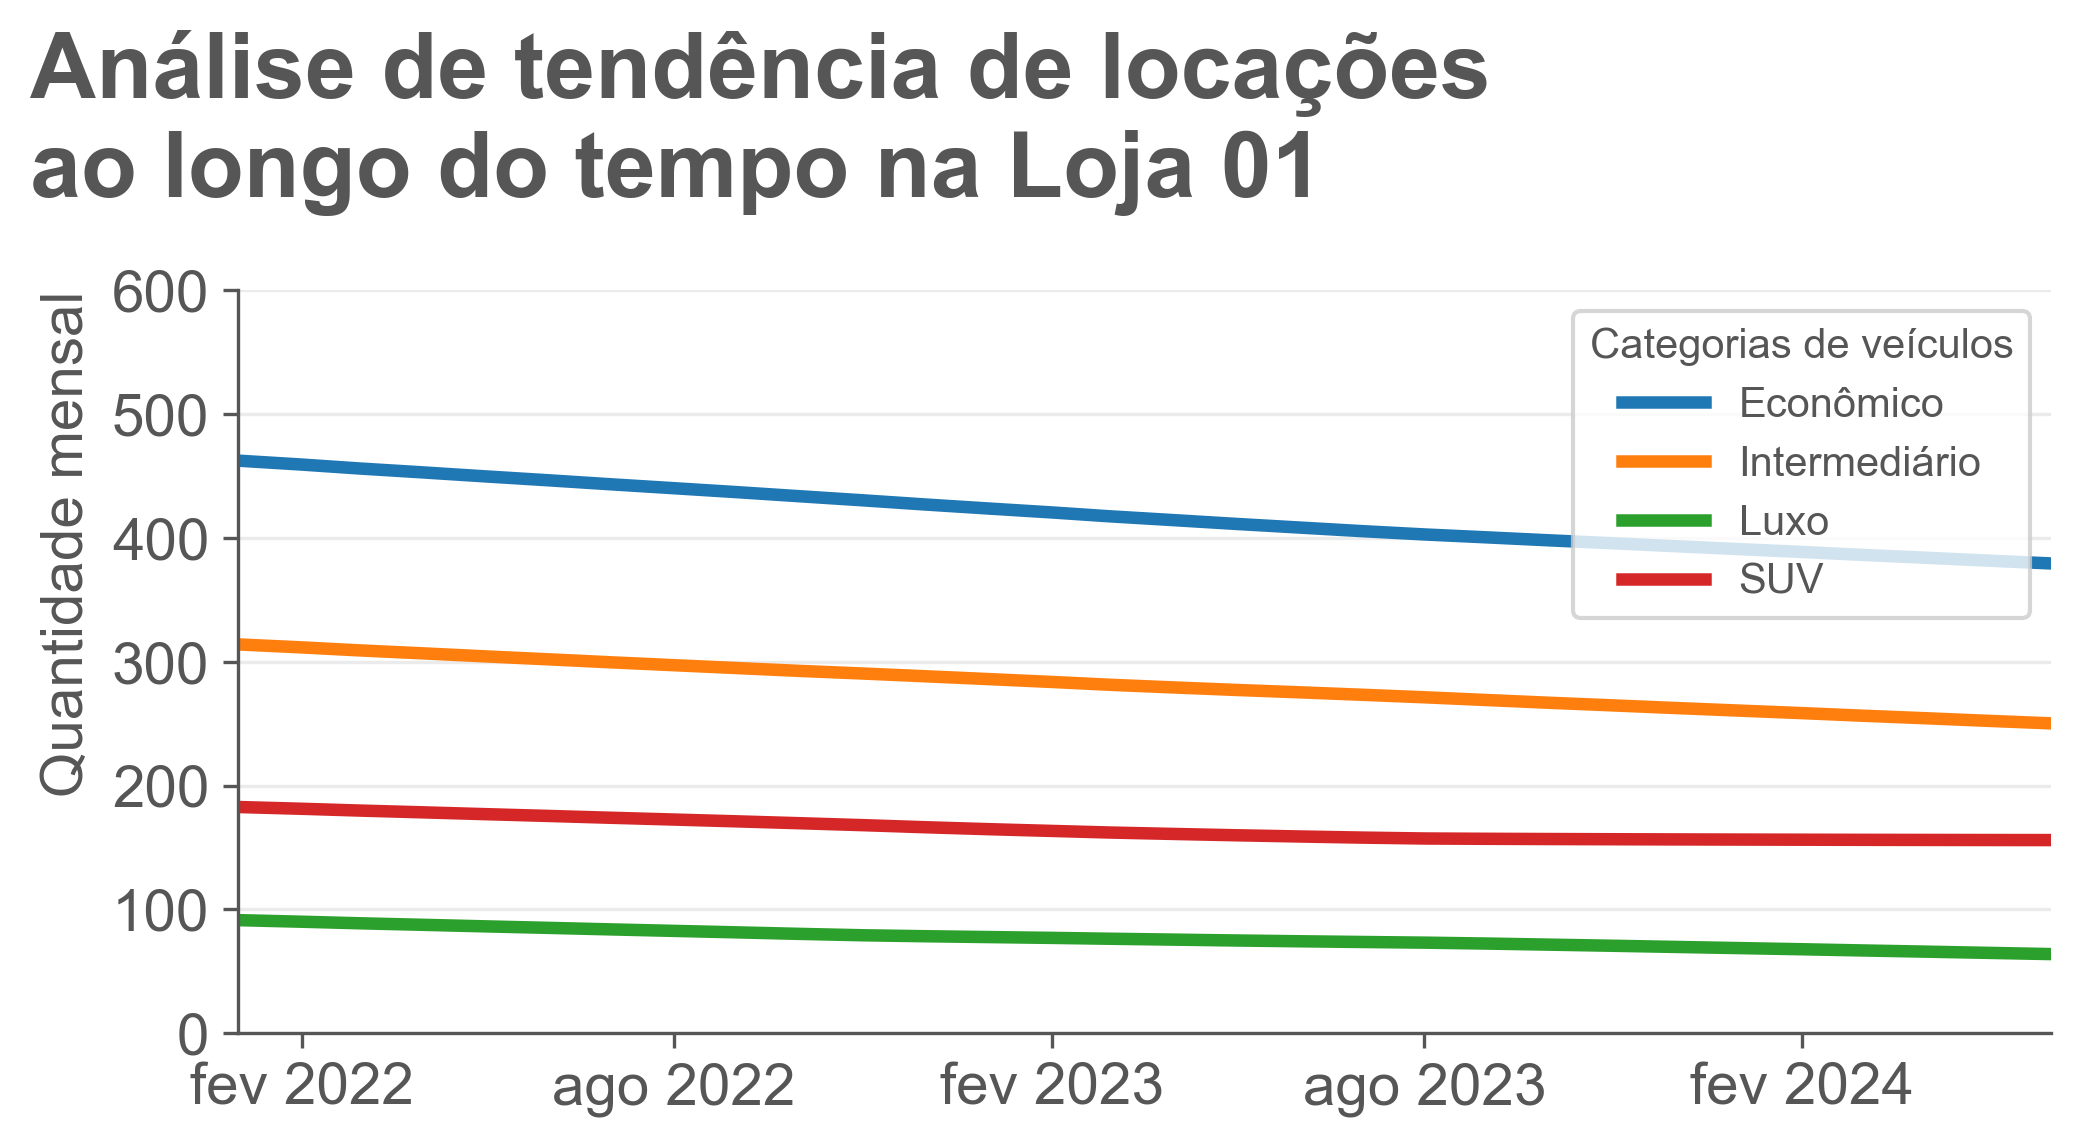

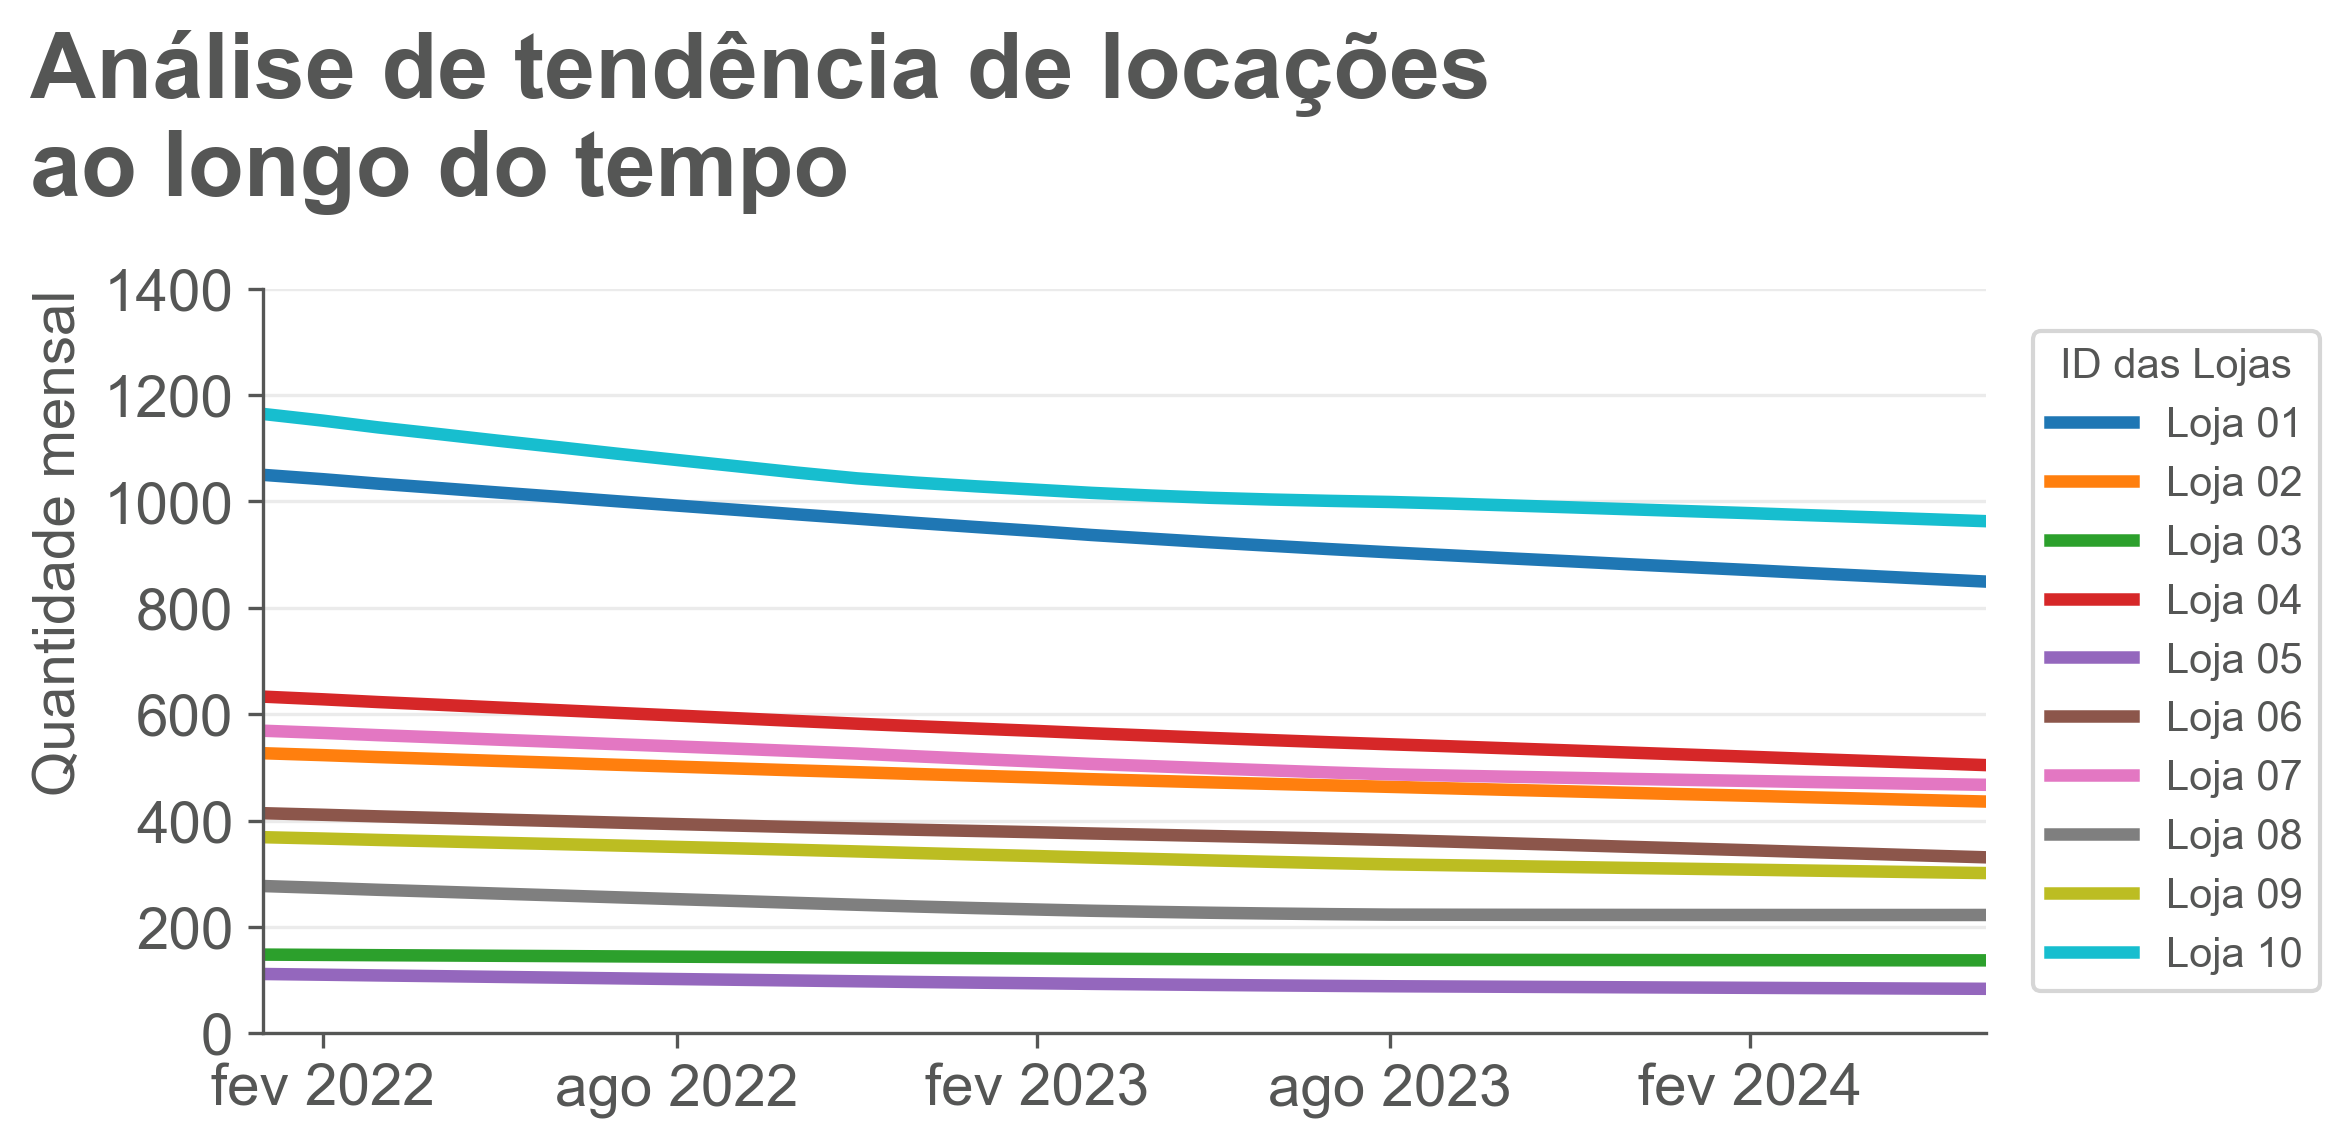

In [ ]:
# Auxiliary Functions


def change_the_granularity_to_month(df: pd.DataFrame) -> pd.DataFrame:
    aggregations = {
        "id_contrato": "count",
        "diaria_media": "mean",
        "valor_total_locacao": "sum",
    }
    df["data_inicio_locacao"] = pd.to_datetime(df["data_inicio_locacao"])
    df["mes"] = df["data_inicio_locacao"].dt.to_period("M")
    df = df.drop(
        columns=["duracao_locacao", "dias_antecedencia", "data_inicio_locacao"]
    )
    df_mensal = (
        df.groupby(["mes", "id_loja", "categoria_veiculo"])
        .agg(aggregations)
        .reset_index()
    )
    df_mensal = df_mensal.rename(columns={"id_contrato": "quantidade_contratos"})
    return df_mensal


def get_mstl_decomposition(df_single_category: pd.DataFrame, column: str):
    df_mstl = df_single_category[["mes", column]].copy()
    df_mstl["Data"] = df_mstl["mes"].dt.to_timestamp()
    df_mstl = df_mstl.set_index("Data")
    if len(df_mstl) < 2 * 3:  # Adicionando uma verificação mínima
        return None
    if len(df_mstl) > 2 * 12:
        decomposition = MSTL(df_mstl[column], periods=[6, 12]).fit()
    elif len(df_mstl) > 2 * 6:
        decomposition = MSTL(df_mstl[column], periods=[3, 6]).fit()
    else:
        decomposition = MSTL(df_mstl[column], periods=3).fit()
    return decomposition


def configure_plot(
    ax,
    title_text,
    y_label,
    legend_title,
    min_date,
    max_date,
    y_upper_lim,
    legend_options,
    title_loc,
):
    ax.set_xlim(min_date, max_date)
    ax.set_ylim([0, int(1.1 * y_upper_lim)])

    date_format = mdates.DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.grid(axis="y", alpha=0.25)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=14, color="#555655"
    )

    leg = ax.legend(title=legend_title, labelcolor="#555655", **legend_options)
    leg.get_title().set_color("#555655")

    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=14, color="#555655")
    ax.text(
        *title_loc,
        title_text,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )

    ax.set_ylim([0, max(ax.get_yticks())])
    plt.tight_layout()


def plot_trends_by_category(df_monthly, stores, vehicles):
    for store in stores:
        fig, ax = plt.subplots(figsize=(7, 4))
        y_upper_lim = 0

        store_data = df_monthly[df_monthly.id_loja == store]
        if store_data.empty:
            plt.close(fig)
            continue

        min_date = store_data["mes"].min().to_timestamp()
        max_date = store_data["mes"].max().to_timestamp()

        for vehicle in vehicles:
            df_filtered = store_data[store_data.categoria_veiculo == vehicle].copy()
            if df_filtered.empty:
                continue

            decomposition = get_mstl_decomposition(df_filtered, "quantidade_contratos")
            if decomposition is None:
                continue

            sns.lineplot(data=decomposition.trend, label=vehicle, ax=ax, linewidth=3)
            y_upper_lim = max(y_upper_lim, decomposition.trend.max())

        title = f"Análise de tendência de locações \nao longo do tempo na {store.replace('LJ', 'Loja')}"
        legend_opts = {"loc": "upper right"}
        configure_plot(
            ax,
            title,
            "Quantidade mensal",
            "Categorias de veículos",
            min_date,
            max_date,
            y_upper_lim,
            legend_opts,
            title_loc=(-0.115, 1.125),
        )

        plt.savefig(f"../img/results/trend_amount_{store}.png", dpi=300)
        if store != "LJ 01":
            plt.close(fig)


def plot_trends_by_store(df_monthly, stores):
    df_by_store = (
        df_monthly.groupby(["mes", "id_loja"])["quantidade_contratos"]
        .sum()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    y_upper_lim = 0

    min_date = df_by_store["mes"].min().to_timestamp()
    max_date = df_by_store["mes"].max().to_timestamp()

    for store in stores:
        df_filtered = df_by_store[df_by_store.id_loja == store].copy()
        if df_filtered.empty:
            continue

        decomposition = get_mstl_decomposition(df_filtered, "quantidade_contratos")
        if decomposition is None:
            continue

        sns.lineplot(
            data=decomposition.trend,
            label=store.replace("LJ ", "Loja "),
            ax=ax,
            linewidth=3,
        )
        y_upper_lim = max(y_upper_lim, decomposition.trend.max())

    title = "Análise de tendência de locações \nao longo do tempo"
    legend_opts = {"loc": "center left", "bbox_to_anchor": (1.015, 0.5)}
    configure_plot(
        ax,
        title,
        "Quantidade mensal",
        "ID das Lojas",
        min_date,
        max_date,
        y_upper_lim,
        legend_opts,
        title_loc=(-0.135, 1.125),
    )

    plt.savefig("../img/results/trend_amount.png", bbox_inches="tight")
    plt.show()


# Execution

locale.setlocale(locale.LC_TIME, "pt_BR.UTF-8")
plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams["mathtext.fontset"] = "custom"
matplotlib.rcParams["mathtext.bf"] = "Arial:bold"
matplotlib.rcParams["mathtext.it"] = "Arial:italic"

# Data Preparation
df_monthly = change_the_granularity_to_month(df.copy())
stores = sorted(df.id_loja.unique().tolist())
vehicles = sorted(df.categoria_veiculo.unique().tolist())

# Graph Generation
plot_trends_by_category(df_monthly, stores, vehicles)
plot_trends_by_store(df_monthly, stores)